## Feature Selection & Cluster Validation
---
This code select clustering features and validate the number of clusters

In [1]:
%pip install pandas
%pip install tsfresh
%pip install warnings
%pip install numpy
%pip install os
%pip install scikit-learn
%pip install time
%pip install hashlib
%pip install scipy
%pip install matplotlib

In [ ]:
import pandas as pd
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
import os
import warnings
import numpy as np
from sklearn.impute import KNNImputer
warnings.filterwarnings("ignore")
mypath = r'..\data\Processed_Gases_Official_Data'
onlyfiles = list(os.listdir(mypath))

import time
import hashlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, Birch
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [2]:
# Calculate air quality score
df = pd.DataFrame(columns=["PM2.5",	"SO2", "NO2", "CO", "Date", "id"])
score = []
for files in onlyfiles:
    cur_df = pd.read_csv(os.path.join(mypath,files),index_col=0)
    cur_df['Date'] = pd.to_datetime(cur_df.From_Date, format="%d-%m-%Y %H:%M")
    cur_df.drop(columns=['To_Date','From_Date'],inplace=True)
    cur_df['id']= files
    cur_df = cur_df[["PM2.5",	"SO2", "NO2", "CO", "Date", "id"]]
    cur_df = cur_df[:1687]
    s = []
    temp = cur_df['PM2.5'].dropna()
    if temp.any():
        s.append(sum(temp>60)/len(temp))
    temp = cur_df['SO2'].dropna()
    if temp.any():
        s.append(sum(temp>80)/len(temp))
    temp = cur_df['NO2'].dropna()
    if temp.any():
        s.append(sum(temp>80)/len(temp))
    temp = cur_df['CO'].dropna()
    if temp.any():
        s.append(sum(temp>4)/len(temp))
    score.append(np.mean(s))
    df = pd.concat([df,cur_df])
score = pd.DataFrame({'id': onlyfiles, 'score': score})


In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 10

In [ ]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [53]:
extracted_features = pd.read_csv(r'\Capstone_final\data\missing_value\features-1.csv')

In [54]:
X = extracted_features.to_numpy()

In [55]:
k, gapdf = optimalK(X, nrefs=5, maxClusters=21)
print('Optimal k is: ', k)

Optimal k is:  20


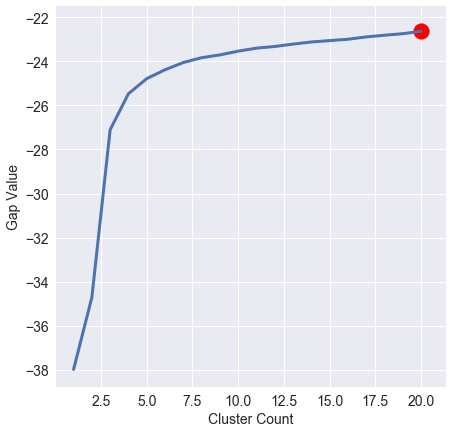

In [56]:
plt.style.use("seaborn")
plt.figure(figsize=(7,7))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=14)
plt.ylabel('Gap Value',fontsize=14)
plt.show()

In [40]:
extracted_features = pd.read_csv(r'\Capstone_final\data\missing_value\stations_features1.csv')

In [41]:
y = extracted_features.Label
extracted_features = extracted_features.iloc[:,3:]

In [42]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

In [43]:
features_filtered = features_filtered.iloc[:,:10]

In [44]:
X = features_filtered.to_numpy()

In [45]:
k, gapdf = optimalK(X, nrefs=5, maxClusters=21)
print('Optimal k is: ', k)

Optimal k is:  20


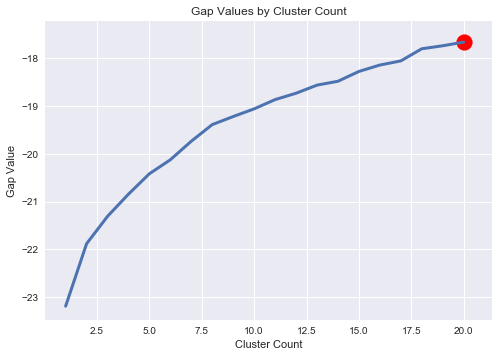

In [46]:

plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [47]:
df = pd.read_csv(r'\Capstone_final\data\missing_value\PM25_10features.csv')

In [48]:
X2 = df.to_numpy()
k2, gapdf2 = optimalK(X2, nrefs=5, maxClusters=21)
print('Optimal k is: ', k2)

Optimal k is:  20


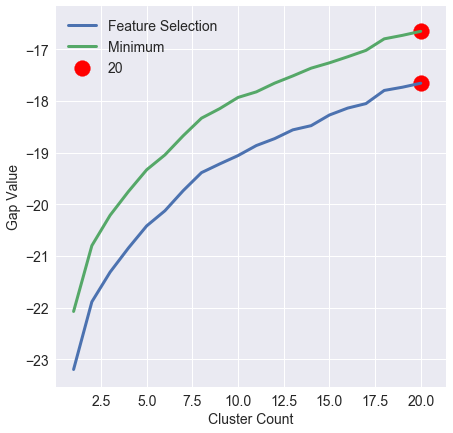

In [51]:
plt.style.use("seaborn")
plt.figure(figsize=(7,7))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.plot(gapdf2.clusterCount, gapdf2.gap, linewidth=3)
plt.scatter(gapdf2[gapdf2.clusterCount == k2].clusterCount, gapdf2[gapdf2.clusterCount == k2].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=14)
plt.ylabel('Gap Value',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Feature Selection', 'Minimum','20'],fontsize=14)
plt.show();